In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import date

import warnings

#hourly_smp data는 시간형식이 일반적인 형태와는 다르게 되어있음
#이를 위해 따로 date_time_split_2를 제작
from processing import date_time_split_1
from processing import date_time_split_2

warnings.filterwarnings(action = 'ignore')
pd.set_option('display.max_columns', 500)
%matplotlib inline

# 1. Data Load

In [2]:
target_original = pd.read_csv('data/target_v1.csv')
weather_original = pd.read_csv('data/weather_v1.csv')
hourly_smp_original = pd.read_csv('data/hourly_smp_v1.csv')

target = target_original.copy()
weather = weather_original.copy()
hourly_smp = hourly_smp_original.copy()

In [3]:
oil_price_cl_original = pd.read_csv('result/oil_price_cl.csv')
oil_price_du_original = pd.read_csv('result/oil_price_du.csv')
oil_price_brt_original = pd.read_csv('result/oil_price_brt.csv')

oil_price_cl = oil_price_cl_original.copy()
oil_price_du = oil_price_du_original.copy()
oil_price_brt = oil_price_brt_original.copy()

## area column이 여러개 존재
### 가장 null값이 적은 area를 선택

In [4]:
area_list = weather['area'].unique()
for ls in area_list :
    null_temp  = weather[weather['area'] == ls]['temp'].isnull().sum()
    print('{} total shape : {}'.format(ls, len(weather[weather['area'] == ls]['temp'])))
    print('{} null shape : {}'.format(ls, null_temp))

184 total shape : 17518
184 null shape : 2
185 total shape : 17512
185 null shape : 20
188 total shape : 17518
188 null shape : 7
189 total shape : 17516
189 null shape : 11
328 total shape : 17488
328 null shape : 72
329 total shape : 17514
329 null shape : 5
330 total shape : 17432
330 null shape : 4
724 total shape : 17423
724 null shape : 7
725 total shape : 17469
725 null shape : 11
726 total shape : 17392
726 null shape : 108
727 total shape : 17517
727 null shape : 4
751 total shape : 17438
751 null shape : 12
752 total shape : 17518
752 null shape : 21
753 total shape : 17287
753 null shape : 15
779 total shape : 17518
779 null shape : 3
780 total shape : 17244
780 null shape : 53
781 total shape : 17399
781 null shape : 22
782 total shape : 17515
782 null shape : 3
792 total shape : 17514
792 null shape : 9
793 total shape : 17467
793 null shape : 132
855 total shape : 17448
855 null shape : 503
861 total shape : 17510
861 null shape : 3
862 total shape : 17005
862 null shape 

**daily smp data 수집 기간**  
**2018년 2월 1일 ~ 2020년 1월 31일**

**데이터 분석 결과 온도를 제외하고는 날씨 데이터에서는 유의미한 변수가 없는것으로 판단**  
**weather data 에서는 temp column만을 추출**

**oil data 수집기간**  
**2006년 4월 18일 ~ 2020년 5월 11일(주말 제외)**

# 2. EDA

## 형식이 유사한 weather와 hourly_smp data 먼저 통합

### weather dataset을 비롯한 모든 데이터의 필요없는 column을 drop하고 변수명을 변환

In [5]:
#weather data에서 temp와 date를 제외한 모든 column drop
weather = weather[weather['area'] == 884]
weather = weather.iloc[:, 1:3]
weather.reset_index(drop = True, inplace = True)
weather.columns = ['date', 'temp']

#hourly_smp에서 date와 smp를 제외한 모든 column drop
hourly_smp.columns = ['dates', 'smp']

In [6]:
#date를 바탕으로 year, month, day, weekday, hour 데이터 생성
weather = date_time_split_1(weather)
hourly_smp = date_time_split_2(hourly_smp)

In [7]:
weather.head()

,temp,year,month,day,weekday,hour
0,3.3,2018,2,1,3,1
1,2.2,2018,2,1,3,2
2,3.8,2018,2,1,3,3
3,0.7,2018,2,1,3,4
4,2.4,2018,2,1,3,5


In [8]:
#weather과 hourly_smp를 결합하여 weather_smp데이터 생성
weather_smp = pd.merge(weather, hourly_smp, on = ['year', 'month', 'day', 'weekday', 'hour'], how = 'outer')

**Training을 위해 2월 1일 ~ 3월 5일까지 데이터를 추가로 생성**

In [9]:
#학습을 위해 2020년 3월 5일까지의 날짜 데이터가 필요함
#2020년 1월 31일까지는 이미 있으므로 2월 1일부터 3월 5일까지를 추가해줌
start_date = date(2020, 2, 1)
end_date = date(2020, 3, 5)

period = pd.date_range(start = start_date, end = end_date)
period = pd.DataFrame({'date' : period})
period = pd.concat([period]*24)
period.sort_values(by = ['date'], inplace = True)
period.reset_index(drop=True, inplace=True)
period = date_time_split_1(period)

hour_time = []
for hour in range(0,24) :
    hour_time.append(hour)
hour_time = hour_time * int(period.shape[0]/24)
period['hour'] = hour_time

temp = [np.nan] * int(period.shape[0])  
period['temp'] = temp

period = period[['temp', 'year', 'month', 'day', 'weekday', 'hour']]

In [10]:
#2월1일부터 3월5일까지 추가 생성된 데이터와 기존 weather_smp데이터를 합쳐 최종 weather_smp data 생성
weather_smp = pd.concat([weather_smp, period])
weather_smp.reset_index(drop=True, inplace=True)
weather_smp.shape

(18336, 7)

## 가장 형식이 차이나는 oil data를 이후 처리

In [11]:
#oil_price에서 필요한 column(date, price)만을 추출함 
oil_price_cl = oil_price_cl.iloc[:, 1:3]
oil_price_du = oil_price_du.iloc[:, 1:3]
oil_price_brt = oil_price_brt.iloc[:, 1:3]

oil_price_cl.columns = ['date', 'cl_price']
oil_price_du.columns = ['date', 'du_price']
oil_price_brt.columns = ['date', 'brt_price']

**weather 과 hourly_smp의 경우 2018년 2월 1일부터 데이터가 존재**  
**oil data의 경우 책정 시점의 3개월 이후의 smp 가격에 영향을 미침**  
**예를 들어 2018년 2월 1일의 smp는 2017년 11월 2일의 원유가격의 영향을 받음**

In [12]:
# target data의 날짜에 맞춰 sampling
# oil의 가격은 3개월 이후의 smp에 영향을 미치므로 2017-11-02 이후의 데이터만을 sampling
oil_price_du = oil_price_du[(oil_price_du['date'] >= '2017-11-02') & (oil_price_du['date'] <= '2019-12-06')] 
oil_price_cl = oil_price_cl[(oil_price_cl['date'] >= '2017-11-02') & (oil_price_cl['date'] <= '2019-12-06')]
oil_price_brt = oil_price_brt[(oil_price_brt['date'] >= '2017-11-02') & (oil_price_brt['date'] <= '2019-12-06')]

#날짜 순서대로 data를 sorting
oil_price_du.sort_values(by = ['date'], inplace = True)
oil_price_cl.sort_values(by = ['date'], inplace = True)
oil_price_brt.sort_values(by = ['date'], inplace = True)

In [13]:
# time data를 만들기 위해 각 데이터별 날짜의 최대 최솟값을 저장해둠
period = pd.date_range(start = oil_price_du.date.min(), end = oil_price_du.date.max())

#index를 0부터 시작되도록 초기화(후에 data를 merge할때 index가 다르면 error 발생)
oil_price_du.reset_index(drop = True, inplace = True)
oil_price_cl.reset_index(drop = True, inplace = True)
oil_price_brt.reset_index(drop = True, inplace = True)

#date를 바탕으로 year, month, day, weekday, hour 데이터 생성
oil_price_cl = date_time_split_1(oil_price_cl)
oil_price_du = date_time_split_1(oil_price_du)
oil_price_brt = date_time_split_1(oil_price_brt)

In [14]:
#time data 생성
time_data = pd.DataFrame({'date' : period})
time_data = date_time_split_1(time_data)

### time_data의 용도

* 기존의 oil data는 주말데이터가 존재하지 않음
* 주말을 채워주기 위해 oil data에서 date만을 추출한 time_data를 새로 생성
* time_data는 oil data와 동일한 기간에서 주말데이터까지 모두 존재함

In [15]:
#time_data를 기준으로 oil data들을 merge함
# 이때 주말의 oil data들은 존재하지 않으므로 모두 null값으로 들어감
oil = pd.merge(left = time_data, right = oil_price_du, how = 'outer')
oil = pd.merge(left = oil, right = oil_price_cl, how = 'outer')
oil = pd.merge(left = oil, right = oil_price_brt, how = 'outer')
oil.head()

,year,month,day,weekday,hour,du_price,cl_price,brt_price
0,2017,11,2,3,0,58.87,54.54,60.62
1,2017,11,3,4,0,60.15,55.64,62.07
2,2017,11,4,5,0,NaN,NaN,NaN
3,2017,11,5,6,0,NaN,NaN,NaN
4,2017,11,6,0,0,61.83,57.35,64.27


In [16]:
#주말 oil data의 null값을 각 column의 평균으로 채움
fillna = {'du_price' : oil.du_price.mean(), 'cl_price' : oil.cl_price.mean(), 'brt_price' : oil.brt_price.mean()}
oil = oil.fillna(value = fillna)

In [17]:
# oil data는 일단위로 존재하므로 각 row를 24개씩 중복하여 시간단위로 변환시켜줌
oil_hour = pd.concat([oil]*24, ignore_index= True)
oil_hour.sort_values(by = ['year', 'month', 'day'], inplace = True)
oil_hour.reset_index(drop=True, inplace=True)

In [18]:
#oil data의 date는 3개월 이전의 데이터이므로 굳이 표기할 필요가 없음
#날짜정보는 모두 drop
oil_hour = oil_hour.iloc[:, 5:]

In [19]:
oil_hour.shape

(18336, 3)

### smp, supply, oil_pirce, weather를 합친 train 제작

In [20]:
print('weather_smp size : {}'.format(weather_smp.shape))
print('oil_hour size : {}'.format(oil_hour.shape))

weather_smp size : (18336, 7)
oil_hour size : (18336, 3)


In [21]:
#weather_smp와 oil_hour를 결합하여 최종 train데이터 생성
train = pd.concat([weather_smp, oil_hour], axis = 1, join = 'inner')

In [22]:
#'year', 'month' 와 같은 날짜 정보를 담은 column들을 조합하여 하나의 date column 생성
time = train['year'].astype(str) + '-' + train['month'].astype(str) + '-' + train['day'].astype(str)
train['date'] = pd.to_datetime(time)

In [23]:
#학습시키기 좋게 column의 위치 재배치
train = train[['date', 'year', 'month', 'day', 'weekday', 'hour', 'temp', 'du_price', 'cl_price', 'brt_price', 'smp']]

In [24]:
train.shape

(18336, 11)

In [25]:
train

,date,year,month,day,weekday,hour,temp,du_price,cl_price,brt_price,smp
0,2018-02-01,2018,2,1,3,1,3.3,58.87,54.54,60.62,116.84
1,2018-02-01,2018,2,1,3,2,2.2,58.87,54.54,60.62,116.84
2,2018-02-01,2018,2,1,3,3,3.8,58.87,54.54,60.62,116.84
3,2018-02-01,2018,2,1,3,4,0.7,58.87,54.54,60.62,116.84
4,2018-02-01,2018,2,1,3,5,2.4,58.87,54.54,60.62,116.84
...,...,...,...,...,...,...,...,...,...,...,...
18331,2020-03-05,2020,3,5,3,19,NaN,62.82,58.43,63.39,NaN
18332,2020-03-05,2020,3,5,3,20,NaN,62.82,58.43,63.39,NaN
18333,2020-03-05,2020,3,5,3,21,NaN,62.82,58.43,63.39,NaN
18334,2020-03-05,2020,3,5,3,22,NaN,62.82,58.43,63.39,NaN


## train data의 feature간 상관관계 분석

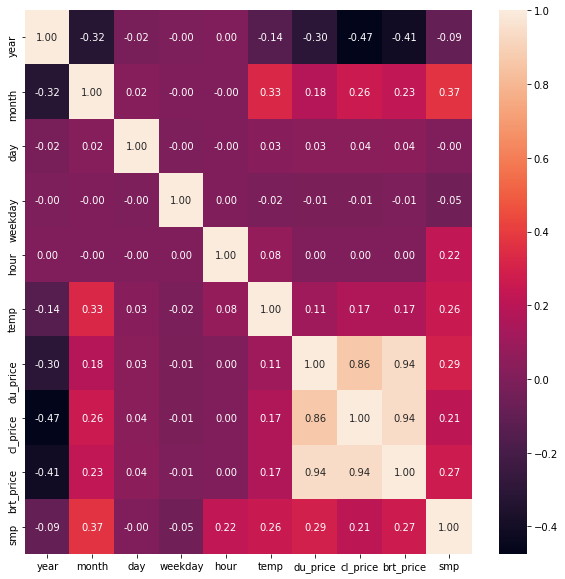

In [27]:
fig, ax = plt.subplots(figsize = (10, 10))

sns.heatmap(train.corr(), annot = True, ax = ax, fmt = '.2f')

# 3. Machine learning modelling 

### 두가지 모델로 나눔
#### 1) 이전의 smp 데이터를 바탕으로 다음 smp 예측
#### 2) 기상 데이터 및 원유가격 데이터를 바탕으로 smp 예측

## 1) keras LSTM 

### normalize

In [32]:
need_normalize = ['temp', 'du_price', 'cl_price', 'brt_price', 'smp']

for col in need_normalize :
    train[col] = (train[col] - train[col].mean())/train[col].std()

### create Windows

In [37]:
seq_len = 50
seq_length = seq_len+1

result = []
for index in range(train.shape[0] - seq_length) :
    result.append(train.iloc[index : index+seq_length, 1:])

### split train and test data

In [48]:
row = int(round(len(result) * 0.9))
train = result[:row]
np.random.shuffle(train)


16456

In [ ]:
x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape